In [19]:
%matplotlib inline
import pandas as pd
import numpy as np
import tables as tb
import datetime
import os

from matplotlib import pyplot as plt; plt.rcParams['figure.figsize'] = 15, 5

DATA_DIR = '../data/interim/'
HDF_FILE = 'interim_data.hdf'

In [20]:
D = pd.read_hdf(DATA_DIR + HDF_FILE, key = '/temperature_ts/wban_94797/D')
t = D.index
T = D['T']

In [21]:
np.max(T)  # Interpolation issues

165152931735.40039

Step 1: Truncate the series to the interval that has observations.  Outside this interval the interpolation blows up.

In [22]:
print('Original bounds: ', t[0], t[-1])

t_obs = t[D['T_flag'] != -1]
D = D[t_obs[0]:t_obs[-1]]  # Truncate dataframe so it is sandwiched between observed values
t = D.index
T = D['T']
print('New bounds: ', t[0], t[-1])

Original bounds:  1953-01-01 05:00:00 2006-01-01 04:00:00
New bounds:  1953-01-01 05:00:00 2005-01-20 01:00:00


In [23]:
t_obs = D.index[D['T_flag'] != -1]
t_interp = D.index[D['T_flag'] == -1]
T_obs = D.loc[t_obs, 'T']
T_interp = D.loc[t_interp, 'T']

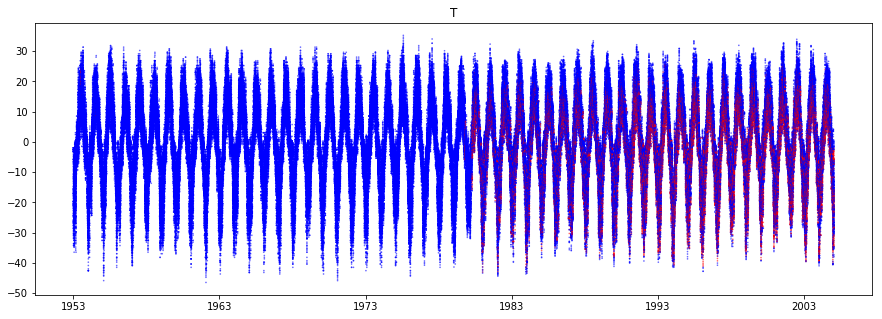

In [33]:
c = ['b' if flag != -1 else 'orange' for flag in D['T_flag']
plt.scatter(t, T, c = c, alpha = 0.5, s = 0.5)
plt.title('T')
#obs = plt.scatter(t_obs, T_obs, marker = '.', alpha = 0.5, s = 0.5, color = 'blue');
#interp = plt.scatter(t_interp, T_interp, marker = '.', alpha = 0.5, s = 0.5, color = 'red');
     #  If I plot one after the other, the red is much more prominant...  Very annoying
#plt.legend((obs, interp), ('Observed', 'Interpolated'), markerscale = 15);

Red dots are interpolated values.

In [45]:
# Centre the data
mu = D['T'].mean()
D.loc[:, 'T'] = D.loc[:, 'T'] - mu
T = D['T']
print('E[T] = ', mu)

E[T] =  -1.59460810988e-17


We want to obtain a stationary "feature" from the data, firt differences are an easy place to start.

In [36]:
T0 = T[0]
dT = T.diff()
dT = dT - dT.mean()  # Center the differences

In [37]:
dT_obs = dT[t_obs]
dT_interp = dT[t_interp]

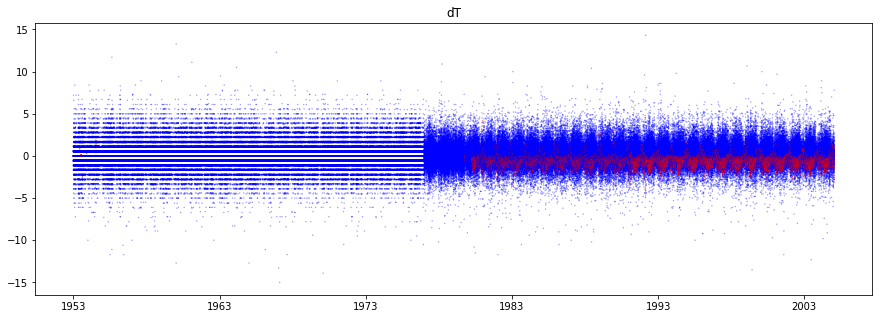

In [38]:
plt.scatter(t, dT, marker = '.', alpha = 0.5, s = 0.5, c = c)
#obs = plt.scatter(t_obs, dT_obs, marker = '.', alpha = 0.5, s = 0.5, color = 'blue');
#interp = plt.scatter(t_interp, dT_interp, marker = '.', alpha = 0.5, s = 0.5, color = 'red');
#plt.legend((obs, interp), ('Observed', 'Interpolated'), markerscale = 15);
plt.title('dT')

It appears that early temperature sensors had rather imprecise readings.

It also appears as though the interpolation introduces some systematic errors.  I used pchip interpolation, which tries to avoid overshoot, so we may be seeing the effects of clipping.  This would particularly make sense if missing data was from regular periods, e.g. at night when the temperature was reaching a minimum.

In [39]:
rolling1w_dT = dT.rolling(window = 7*24)  # 1 week rolling window of dT
rolling1m_dT = dT.rolling(window = 30*24)  # 1 month rolling window of dT
rolling1y_dT = dT.rolling(window = 365*24)  # 1 year rolling dindow of dT

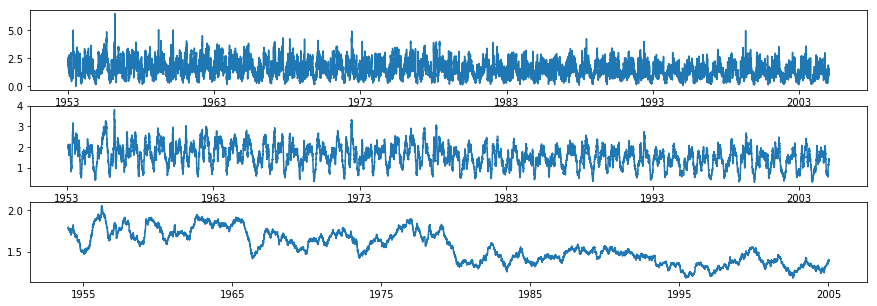

In [40]:
fig, axes = plt.subplots(3, 1)
axes[0].plot(rolling1w_dT.var())
axes[1].plot(rolling1m_dT.var())
axes[2].plot(rolling1y_dT.var())

It looks like there is still some nonstationarity in the first differences.

In [41]:
from itertools import product
t_days = [t[np.logical_and(t.month == m, t.day == d)] for m, d in product(range(1,13), range(1, 32))]
day_vars = pd.Series(dT[ti].var() for ti in t_days)
day_vars = day_vars.dropna()

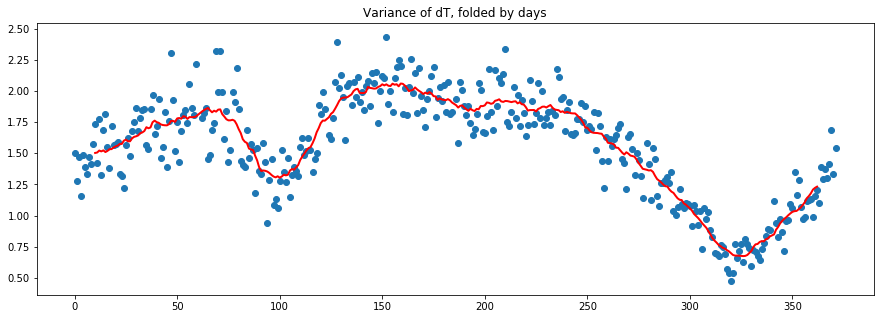

In [44]:
plt.scatter(day_vars.index, day_vars)
r = day_vars.rolling(window = 20, center = True)
plt.plot(day_vars.index, r.mean(), color = 'red', linewidth = 2)
plt.title('Variance of dT, folded by days')

This is approximately the daily variance of temperatures.  There is definitely a significant amount of heteroscedasticity.  Taking additional differences does not help.  On the bright side, it is cyclic.